In [157]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import csv

In [168]:
dframe_path = 'data/cabauw/processed.csv'

try:
    df = pd.read_csv(dframe_path, na_values='--')
except UnicodeDecodeError:
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
df = df[df.ds != 201603]    

lets start with a baseline. data doesnt follow the functions given in the literature, so while I fix it we can change those functions to fit the data. given the definition of $\phi_m$ for $\xi>0$:

$$
\phi_m(\xi)=a+b\xi
$$

we can fit a simple linear model with $\xi$ as only feature. for $\xi<0$ we have

$$
\phi_m(\xi)=(1+c\xi)^d
$$

whose derivatives are

$$
\frac{\partial \phi_m}{\partial c}=\xi d(1+c\xi)^{d-1}
$$

$$
\frac{\partial \phi_m}{\partial d}=(1+c\xi)^d\ln(1+c\xi)
$$

considering the usual least squares with l2 regularization we have the loss function

$$
E=\frac{1}{N}\sum_i(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))^2+\frac{1}{2}\sum_p p^2
$$

and its derivative with respect to the parameter $p$

$$
\frac{\partial E}{\partial p}=\frac{2}{N}\sum_i\frac{\partial}{\partial p}\phi_m(\xi_i,p)\cdot(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))+p
$$

In [169]:
def phim(zL, a, b, c, d):
    mask = zL >= 0
    yy = np.zeros(len(zL))
    yy[mask] = a + b * zL[mask]
    yy[~mask] = np.power(1 + c * zL[~mask], d)
    assert all(np.isfinite(zL))
    assert all(np.isfinite(yy)), (a, b, c, d)
    return yy


def phim_prime(zL, a, b, c, d):
    dpda = np.ones(len(zL))
    dpdb = np.ones(len(zL)) * zL
    
    inner = 1 + c * zL
    dpdc = zL * d * np.power(inner, d - 1)
    dpdd = np.sign(inner) * np.log(np.abs(inner)) * np.power(inner, d)

    return dpda, dpdb, dpdc, dpdd

In [170]:
params = [1, 4.8, -19.3, -0.25]
lrate = 0.025
regu = 0.1

for i in range(1000):
    preds = phim(df.zL_m, *params)
    err = np.mean((df.phi_m - preds)**2)
    der = phim_prime(df.zL_m, *params)

    lr = lrate / np.sqrt(i + 1)
    for p, parpr in enumerate(der):
        grad = 2 * np.mean((preds - df.phi_m) * parpr) + regu * params[p]
        params[p] -= lr * grad

    if i % 25 == 0:
        print(i, err, params)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power


0 5.0389498628838805 [1.1032411990516315, 4.781311686051051, -19.277586403565223, -0.2619023047461113]
25 3.5101012208807543 [1.7986951156951987, 4.6194385182981845, -19.655349990685526, -0.331677673759506]
50 3.0927727259106024 [2.0935032224996206, 4.52786675481414, -20.387693243062397, -0.3336051616555835]
75 2.818976236878223 [2.295249520355952, 4.454738161971297, -20.696618375756206, -0.29717570095327045]
100 2.581380644247563 [2.448272120146884, 4.392331597163859, -20.634100896546776, -0.22899434310892677]
125 2.3390265578922413 [2.569556954645464, 4.337794404332458, -20.52432315311505, -0.13395661760690414]
150 2.065807670007862 [2.667249143258913, 4.290087273298432, -20.421052232461303, -0.01640552425177011]
175 1.7524574362952374 [2.7454383091367984, 4.249324507338646, -20.321372656746846, 0.11757965746032417]
200 1.4509077940853594 [2.806184237836682, 4.21649758811255, -20.229169919024375, 0.2493441597763141]
225 1.2819455128605317 [2.8519646289231217, 4.192020888269371, -20.1

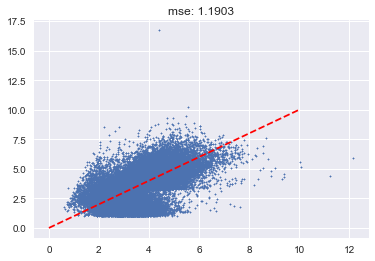

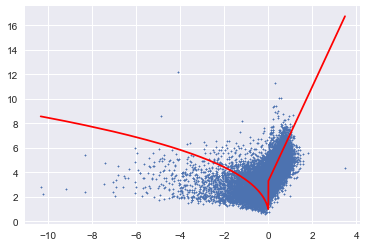

In [172]:
pred = phim(df.zL_m, *params)
rmse = np.mean(np.power(pred - df.phi_m, 2))
plt.scatter(df.phi_m, pred, s=1)
plt.title('mse: %.4f' % rmse)
plt.plot([0, 10], [0, 10], 'r--')
plt.show()

plt.scatter(df.zL_m, df.phi_m, s=1)
plt.plot(df.zL_m.sort_values(), phim(df.zL_m.sort_values(), *params), 'r')
plt.show()

NB by predicting phi_m-2 we can get results that are similar to those in the literature

In [154]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split


pred_data = df[[
    'year', 'month', 'daym', 'hday',
    'air_dens', 'H', 'LE', 'surf_temp',
    'zL_m', 'phi_m'
]]


train_x, test_x, train_y, test_y = train_test_split(pred_data.drop('phi_m', axis=1),
                                                    pred_data.phi_m, test_size=0.1)

In [150]:
grid = {
    'n_neighbors': [5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}


gs = GridSearchCV(
    KNeighborsRegressor(), grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error',
)
gs.fit(train_x, train_y)
gs.best_score_, gs.best_params_

(-0.00048493935925980597, {'n_neighbors': 5, 'p': 1, 'weights': 'distance'})

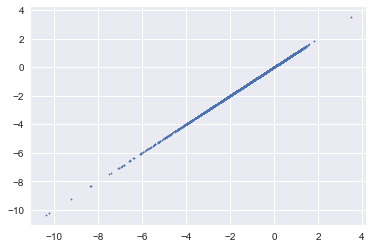

In [151]:
plt.scatter(train_y, gs.best_estimator_.predict(train_x), s=1)